In [1]:
import os
import torch
import yaml
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from monai.data import Dataset, decollate_batch
from monai.transforms import Compose, LoadImaged, ScaleIntensityd, NormalizeIntensityd, LambdaD, Resized, Activations, AsDiscrete
from monai.losses import FocalLoss
from monai.utils import set_determinism
from monai.networks.nets import DenseNet121
from monai.metrics import ROCAUCMetric
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, average_precision_score, matthews_corrcoef
from torch.utils.data import DataLoader
from monai.visualize import GradCAM, SmoothGrad, GuidedBackpropSmoothGrad, OcclusionSensitivity  #model for the XAI
import matplotlib.pyplot as plt
import random
import torch
from scipy.stats import t
import csv

/home/vito/fortunom/projects/AI4Health/notebooks/fortunom/master-thesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/home/vito/fortunom/projects/AI4Health/data/fortunom/covidxct/proc_slices_metadata.csv')
df = df[(df["use"] == True)]
df = df[df["split"] == "test"]

# comment to not use syn data
df = pd.read_csv('/home/vito/fortunom/projects/AI4Health/notebooks/fortunom/master-thesis/data/syn_gt/gen_1.csv')

reference_combinations = df[["sex", "age_group"]].drop_duplicates().values.tolist()
print(reference_combinations)

[['M', '20-40'], ['M', 'Over 80'], ['F', 'Under 20'], ['M', 'Under 20'], ['F', '20-40'], ['F', 'Over 80']]


In [6]:
from pathlib import Path
PROJECT_ROOT = Path("/home/vito/fortunom/projects/AI4Health/notebooks/fortunom/master-thesis")

def resolve_path(p):
    p = Path(p)
    if not p.is_absolute():
        return PROJECT_ROOT / p
    return p

def build_monai_data(df_subset, image_col, target_col):

    return [{"img": str(resolve_path(row[image_col])), "target": int(row[target_col])} for _, row in df_subset.iterrows()]

def get_eval_transform():
    return Compose([
        LoadImaged(keys=["img"], ensure_channel_first=True),
        ScaleIntensityd(keys=["img"]),
        LambdaD(keys=["img"], func=lambda x: x.repeat(3, 1, 1)),
        NormalizeIntensityd(keys=["img"], subtrahend=torch.tensor([0.485, 0.456, 0.406]),
                            divisor=torch.tensor([0.229, 0.224, 0.225]), channel_wise=True),
        Resized(keys=["img"], spatial_size=(256, 256)),
    ])

def evaluate_on_test(model, test_df, image_path_col):
    device = next(model.parameters()).device
    test_ds = Dataset(data=build_monai_data(test_df, image_path_col, "label"), transform=get_eval_transform())
    test_loader = DataLoader(test_ds, batch_size=128, num_workers=2)

    post_pred = Activations(softmax=True)
    post_target = AsDiscrete(to_onehot=2)
    post_discrete = AsDiscrete(argmax=True, to_onehot=2)
    auc_metric = ROCAUCMetric(average="macro")

    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            x = batch["img"].to(device)
            targets = batch["target"].to(device)
            outputs = model(x)
            y_pred = torch.cat([y_pred, outputs], dim=0)
            y = torch.cat([y, targets], dim=0)

    y_pred_probs = post_pred(y_pred)
    y_true = [post_target(i) for i in decollate_batch(y, detach=False)]
    y_pred_bin = [post_discrete(i) for i in decollate_batch(y_pred_probs, detach=False)]
    y_true_classes = y.cpu().numpy()
    y_pred_classes = torch.argmax(y_pred_probs, dim=1).cpu().numpy()

    labels_present = np.unique(y_true_classes)

    if len(labels_present) < 2:
        auc = np.nan
        auc_pr = np.nan
        mcc = np.nan
    else:
        # AUC (ROC)
        auc_metric.reset()
        auc_metric(y_pred_probs, y_true)
        auc = auc_metric.aggregate().item()

        # AUC-PR (macro) using existing one-hot encoded y_true
        y_true_onehot = torch.stack(y_true).cpu().numpy()
        y_probs = y_pred_probs.cpu().numpy()
        auc_pr = average_precision_score(y_true_onehot, y_probs, average="macro")

        # MCC 
        mcc = matthews_corrcoef(y_true_classes, y_pred_classes)

    acc = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, labels=labels_present, average='macro', zero_division=0)
    recall = recall_score(y_true_classes, y_pred_classes, labels=labels_present, average='macro', zero_division=0)
    precision = precision_score(y_true_classes, y_pred_classes, labels=labels_present, average='macro', zero_division=0)

    print(f"TEST: ACC={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}, REC={recall:.4f}, PREC={precision:.4f}, AUC-PR={auc_pr:.4f}, MCC={mcc:.4f}")
    print(classification_report(y_true_classes, y_pred_classes,digits=4, zero_division=0))

    metrics = {"test_f1": f1, "test_acc": acc, "test_auc": auc, "test_recall": recall, "test_precision": precision, "test_auc_pr": auc_pr, "test_mcc": mcc}

    result_df = test_df.copy()
    result_df["y_true"] = y_true_classes
    result_df["y_pred"] = y_pred_classes
    return metrics, result_df

def get_gradcam_overlay(model, image_path, label, class_idx, layer="features.transition2.relu"):
    device = next(model.parameters()).device
    sample = {"img": image_path, "target": label}
    transform = get_eval_transform()
    data = transform(sample)
    image_tensor = data["img"].unsqueeze(0).to(device)

    cam = GradCAM(nn_module=model, target_layers=layer)
    cam_map = cam(image_tensor, class_idx=class_idx).squeeze().cpu().numpy()

    img_np = data["img"].cpu().numpy().squeeze()
    img_gray = img_np.mean(axis=0)

    return img_gray, cam_map  # return both grayscale base and cam overlay

def get_smoothgrad_overlay(model, image_path, label, class_idx, stdev_spread=0.15, n_samples=25):
    device = next(model.parameters()).device
    sample = {"img": image_path, "target": label}
    transform = get_eval_transform()
    data = transform(sample)
    image_tensor = data["img"].unsqueeze(0).to(device)  # shape (1, C, H, W)

    # SmoothGrad setup
    explainer = SmoothGrad(model=model, stdev_spread=stdev_spread, n_samples=n_samples, magnitude=True, verbose=False)

    saliency_map = explainer(image_tensor, index=class_idx).squeeze().cpu().numpy()  # shape (H, W)
    saliency_map = np.abs(saliency_map).mean(axis=0)  # average across channels (if more than 1)

    img_np = data["img"].cpu().numpy().squeeze()
    img_gray = img_np.mean(axis=0)  # base grayscale image

    return img_gray, saliency_map


def get_guidedback_smooth_overlay(model, image_path, label, class_idx):
    device = next(model.parameters()).device
    sample = {"img": image_path, "target": label}
    transform = get_eval_transform()
    data = transform(sample)
    image_tensor = data["img"].unsqueeze(0).to(device)

    # Compute GuidedBackpropSmoothGrad
    guided_back = GuidedBackpropSmoothGrad(model, n_samples=25, stdev_spread=0.15)
    saliency = guided_back(image_tensor, index=class_idx).squeeze().cpu().numpy()

    # Normalize saliency map
    saliency = np.abs(saliency).mean(axis=0)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

    img_np = data["img"].cpu().numpy().squeeze()
    img_gray = img_np.mean(axis=0)

    return img_gray, saliency

In [4]:
def get_occlusion_map(model, image_path, label, class_idx):
    device = next(model.parameters()).device
    sample = {"img": image_path, "target": label}
    transform = get_eval_transform()
    data = transform(sample)
    image_tensor = data["img"].unsqueeze(0).to(device)

    # Init occlusion object
    occ = OcclusionSensitivity(nn_module=model, mask_size=16, n_batch=16, mode="mean_img", verbose=True)

    # Run occlusion (slow)
    occ_map, _ = occ(x=image_tensor, b_box=None)  # full image
    occ_map = occ_map.squeeze().cpu().numpy()  # shape: (H, W, num_classes)

    # We take the score map for the target class
    occ_score = occ_map[..., class_idx]
    occ_score = (occ_score - occ_score.min()) / (occ_score.max() - occ_score.min() + 1e-8)

    # Base image for visualization
    img_np = data["img"].cpu().numpy().squeeze()
    img_gray = img_np.mean(axis=0)

    return img_gray, occ_score

In [7]:
sex = "F"
age_group = "20-40"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=2, pretrained=True).to(device)
model_path = "/home/vito/fortunom/projects/AI4Health/notebooks/fortunom/master-thesis/models/utility_eval/classifier_trained_real_HO1.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

sub_df = df[(df["sex"] == sex) & (df["age_group"] == age_group)]
print(f"Evaluating on subgroup: {sex} and {age_group}")
#test_metrics, result_df = evaluate_on_test(model, sub_df, "image_path")
test_metrics, result_df = evaluate_on_test(model, sub_df, "syn_path")


Evaluating on subgroup: F and 20-40


Evaluating: 100%|██████████| 39/39 [00:32<00:00,  1.19it/s]


TEST: ACC=0.8967, F1=0.8942, AUC=0.9975, REC=0.8910, PREC=0.9172, AUC-PR=0.9975, MCC=0.8077
              precision    recall  f1-score   support

           0     0.8371    0.9981    0.9105      2565
           1     0.9972    0.7839    0.8778      2304

    accuracy                         0.8967      4869
   macro avg     0.9172    0.8910    0.8942      4869
weighted avg     0.9129    0.8967    0.8950      4869



TP: found 1806 sample(s)


Computing GuidedBackpropSmoothGrad: 100%|██████████| 25/25 [00:01<00:00, 12.81it/s]


TN: found 2560 sample(s)


Computing GuidedBackpropSmoothGrad: 100%|██████████| 25/25 [00:01<00:00, 12.86it/s]


FP: found 5 sample(s)


Computing GuidedBackpropSmoothGrad: 100%|██████████| 25/25 [00:01<00:00, 12.90it/s]


FN: found 498 sample(s)


Computing GuidedBackpropSmoothGrad: 100%|██████████| 25/25 [00:01<00:00, 12.87it/s]


GradCAM results:


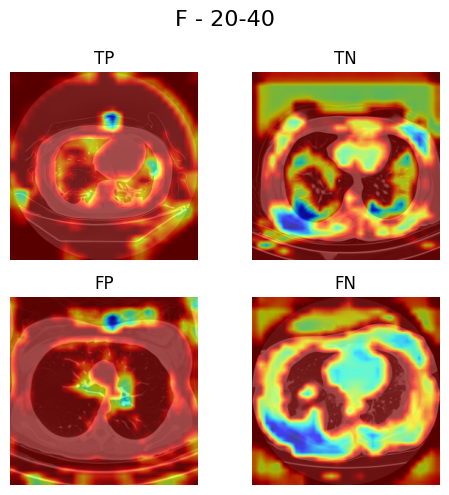

Smooth CAM results:


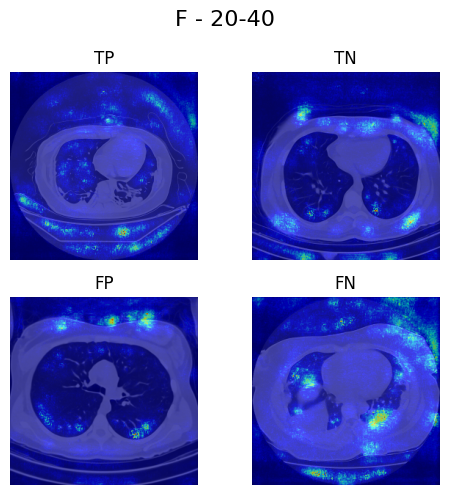

Guided Backprop Smooth Grad Results:


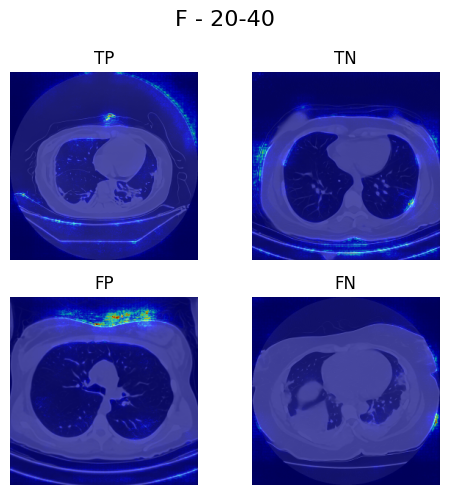

In [10]:
overlay_dict_cam = {}
overlay_dict_smooth = {}
overlay_dict_grad = {}

for category, condition in {
    "TP": lambda df: (df.y_true == 1) & (df.y_pred == 1),
    "TN": lambda df: (df.y_true == 0) & (df.y_pred == 0),
    "FP": lambda df: (df.y_true == 0) & (df.y_pred == 1),
    "FN": lambda df: (df.y_true == 1) & (df.y_pred == 0),
}.items():
    sample_row = result_df[condition(result_df)]
    print(f"{category}: found {len(sample_row)} sample(s)")
    if len(sample_row) > 0:
        sample = sample_row.sample(1).iloc[0]
        #image_path = sample["image_path"]
        image_path = str(resolve_path(sample["syn_path"]))
        true_label = sample["y_true"]
        pred_label = sample["y_pred"]

        base_img, cam = get_gradcam_overlay(model, image_path, true_label, pred_label)
        base_img, smooth = get_smoothgrad_overlay(model, image_path, true_label, pred_label)
        base_img, saliency = get_guidedback_smooth_overlay(model, image_path, true_label, pred_label)
        
        overlay_dict_cam[category] = (base_img, cam)
        overlay_dict_smooth[category] = (base_img, smooth)
        overlay_dict_grad[category] = (base_img, saliency)

if overlay_dict_cam:
    print("GradCAM results:")
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    fig.suptitle(f"{sex} - {age_group}", fontsize=16)
    categories = ["TP", "TN", "FP", "FN"]
    for i, category in enumerate(categories):
        row, col = divmod(i, 2)
        ax = axs[row][col]
        # if category was found in the subgroup plot it
        if category in overlay_dict_cam:
            base_img, cam = overlay_dict_cam[category]
            ax.imshow(base_img, cmap="gray")
            ax.imshow(cam, cmap="jet", alpha=0.7)
            ax.set_title(category)
        # else empty plot
        else:
            ax.axis("off")
            ax.set_title(f"{category} (N/A)")
    for ax_row in axs:
        for ax in ax_row:
            ax.axis("off")
    plt.tight_layout()
    plt.show() 

if overlay_dict_smooth:
    print("Smooth CAM results:")
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    fig.suptitle(f"{sex} - {age_group}", fontsize=16)
    categories = ["TP", "TN", "FP", "FN"]
    for i, category in enumerate(categories):
        row, col = divmod(i, 2)
        ax = axs[row][col]
        # if category was found in the subgroup plot it
        if category in overlay_dict_smooth:
            base_img, smooth = overlay_dict_smooth[category]
            ax.imshow(base_img, cmap="gray")
            ax.imshow(smooth, cmap="jet", alpha=0.7)
            ax.set_title(category)
        # else empty plot
        else:
            ax.axis("off")
            ax.set_title(f"{category} (N/A)")
    for ax_row in axs:
        for ax in ax_row:
            ax.axis("off")
    plt.tight_layout()
    plt.show() 

if overlay_dict_grad:
    print("Guided Backprop Smooth Grad Results:")
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    fig.suptitle(f"{sex} - {age_group}", fontsize=16)
    categories = ["TP", "TN", "FP", "FN"]
    for i, category in enumerate(categories):
        row, col = divmod(i, 2)
        ax = axs[row][col]
        # if category was found in the subgroup plot it
        if category in overlay_dict_grad:
            base_img, silency = overlay_dict_grad[category]
            ax.imshow(base_img, cmap="gray")
            ax.imshow(silency, cmap="jet", alpha=0.7)
            ax.set_title(category)
        # else empty plot
        else:
            ax.axis("off")
            ax.set_title(f"{category} (N/A)")
    for ax_row in axs:
        for ax in ax_row:
            ax.axis("off")
    plt.tight_layout()
    plt.show() 

TP: found 63 sample(s)


  0%|          | 0/106 [00:00<?, ?it/s]

100%|██████████| 106/106 [00:03<00:00, 30.05it/s]


TN: found 254 sample(s)


100%|██████████| 106/106 [00:03<00:00, 31.33it/s]


FP: found 0 sample(s)
FN: found 4 sample(s)


100%|██████████| 106/106 [00:03<00:00, 31.41it/s]


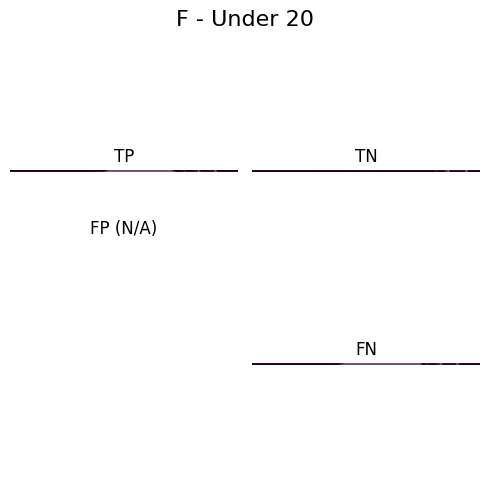

In [8]:
overlay_dict = {}

for category, condition in {
    "TP": lambda df: (df.y_true == 1) & (df.y_pred == 1),
    "TN": lambda df: (df.y_true == 0) & (df.y_pred == 0),
    "FP": lambda df: (df.y_true == 0) & (df.y_pred == 1),
    "FN": lambda df: (df.y_true == 1) & (df.y_pred == 0),
}.items():
    sample_row = result_df[condition(result_df)]
    print(f"{category}: found {len(sample_row)} sample(s)")
    if len(sample_row) > 0:
        sample = sample_row.sample(1).iloc[0]
        image_path = sample["image_path"]
        true_label = sample["y_true"]
        pred_label = sample["y_pred"]

        base_img, occlusion_map = get_occlusion_map(model, image_path, true_label, pred_label)
        overlay_dict[category] = (base_img, occlusion_map)

if overlay_dict:
    fig, axs = plt.subplots(2, 2, figsize=(5, 5))
    fig.suptitle(f"{sex} - {age_group}", fontsize=16)
    categories = ["TP", "TN", "FP", "FN"]
    for i, category in enumerate(categories):
        row, col = divmod(i, 2)
        ax = axs[row][col]
        # if category was found in the subgroup plot it
        if category in overlay_dict:
            base_img, occlusion_map = overlay_dict[category]
            ax.imshow(base_img, cmap="gray")
            ax.imshow(occlusion_map, cmap="jet", alpha=0.6)
            ax.set_title(category)
        # else empty plot
        else:
            ax.axis("off")
            ax.set_title(f"{category} (N/A)")
    for ax_row in axs:
        for ax in ax_row:
            ax.axis("off")
    plt.tight_layout()
    plt.show() 